In [2]:
import numpy as np
import torch
import torch.nn as nn                     # neural networks
import math


#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


#### Transport equation in segregation direction, assuming imcompressible flow
$$ \frac{\partial c_i}{\partial t} +\frac{\partial ({w_{seg,i} c_i)}}{\partial z} = \frac{\partial }{\partial z} ( D \frac{\partial c_i }{\partial z} ) $$

Segregation velocity model:
$$ w_{seg,i} = 0.26 \ln R_d \dot \gamma (1-c_i)$$


Diffusion coefficient:
$$ D = 0.042 \dot\gamma (c_ld_l + c_s d_s)^2$$

<!-- $$ D = 0.0084 (1+c_l)$$ -->

<!-- So final pde becomes:
$$ \frac{\partial c_i}{\partial t} +\frac{\partial ({18.2 (1-c_i) c_i)}}{\partial z} = \frac{\partial }{\partial z} ( 0.0084 (1+c_l) \frac{\partial c_i }{\partial z} ) $$

$$ \frac{\partial c_i}{\partial t} +  (18.2 -36.4 c_i)\frac{\partial c_i}{\partial z} =  0.0084(1+c_i) \frac{\partial ^2 c_i}{\partial z^2} + 0.0084 (\frac{\partial  c_i}{\partial z})^2$$ -->

#### 

In [55]:
class Net(nn.Module):
    def __init__(self):

        # 6 layer neural network
        super(Net, self).__init__()
        self.ln1 = nn.LayerNorm(100)
        self.ln2 = nn.LayerNorm(100)
        self.ln3 = nn.LayerNorm(100)
        self.ln4 = nn.LayerNorm(100)

        self.hidden_layer1 = nn.Linear(1,100)
        self.hidden_layer2 = nn.Linear(100,100)
        self.hidden_layer3 = nn.Linear(100,100)
        self.hidden_layer4 = nn.Linear(100,100)
        self.hidden_layer5 = nn.Linear(100,100)
        self.output_layer = nn.Linear(100,1)
        self.mse=torch.nn.MSELoss()
        
        # particle properties in S.I unit
        self.rd=2
        self.dl=0.004
        self.rho=1000
        self.c_diffusion=0.042
        self.ds=self.dl/self.rd
        self.rds=1/self.rd
        self.ml=4/3*math.pi*0.002**3*self.rho
        self.ms=4/3*math.pi*0.001**3*self.rho
        
        
        # flow configuration (uniform shear)
        self.gamma=100
        self.phi=0.55
        self.g=9.81
        self.h0=0.01
        self.p0=self.h0*self.rho*self.g*self.phi

        # segregation force calculation
        self.theta=torch.tensor(np.cos(0), dtype=torch.float32, requires_grad=True).to(device)  
        #  Duan et al. 2024
        _intruder_l=(1-1.43*np.exp(-self.rd/0.92))*(1+3.55*np.exp(-self.rd/2.94))*self.phi
        _intruder_s=(1-1.43*np.exp(-self.rds/0.92))*(1+3.55*np.exp(-self.rds/2.94))*self.phi

        self.intruder_l=torch.tensor(_intruder_l, dtype=torch.float32, requires_grad=True).to(device) 
        self.intruder_s=torch.tensor(_intruder_s, dtype=torch.float32, requires_grad=True).to(device) 

    def forward(self, z):
        # if time dimensino is considered, concatenated first, i.e. torch.cat([z,t],axis=1) 
        layer1_out = self.ln1(torch.sigmoid(self.hidden_layer1(z)))
        layer2_out = self.ln2(torch.sigmoid(self.hidden_layer2(layer1_out)))
        layer3_out = self.ln3(torch.sigmoid(self.hidden_layer3(layer2_out)))
        layer4_out = self.ln4(torch.sigmoid(self.hidden_layer4(layer3_out)))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output
    
    def loss(self):


        # PDE loss    
        z_collocation = np.random.uniform(low=0.0, high=0.1, size=(10001,1))

        z = torch.tensor(z_collocation, dtype=torch.float32, requires_grad=True).to(device) 

        c = self(z) 
        
        p=self.rho*self.phi*self.g*z+self.p0
        inert=self.gamma*(c*0.004+(1-c)*(0.004/self.rd))/torch.sqrt(p/self.rho);
        mu_eff=0.364+(0.772-0.364)/(0.434/inert+1)
        eta=mu_eff*p/self.gamma

        mixture_l=(self.intruder_l-self.theta)*torch.tanh((self.theta-self.intruder_s)/(self.intruder_l-self.theta)*self.ml/self.ms*(1-c)/c)
        mixture_s=-(self.intruder_l-self.theta)*c/(1-c)*self.ms/self.ml*torch.tanh((self.theta-self.intruder_s)/(self.intruder_l-self.theta)*self.ml/self.ms*(1-c)/c)
        

        cd=(2-7*math.exp(-2.6*self.rd))+0.57*inert*self.rd

        wseg=mixture_l*self.ml*self.g / (cd*math.pi*eta*0.004)

        c_z = torch.autograd.grad(c.sum(), z, create_graph=True)[0]
        
        # Duan et al. 2024  
        pde=(wseg*c-0.042*self.gamma*torch.square((1-c)*self.ds+c*self.dl)*c_z)*1000

        # Schlick et al. 2015
        # simplified with constant diffusion coefficient
        # pde = (1/0.1 *(1-c)*c - c_z )*10

        target = torch.zeros_like(pde,requires_grad=False)
        pde_loss=self.mse(pde,target)


        # Mass conservation loss
        x_bc = torch.linspace(0, 0.1, 10001,requires_grad=True).to(device)
        x_bc = x_bc.unsqueeze(-1)
        u_bc = self(x_bc)
        u_bc=torch.mean(u_bc)
        
        target=torch.zeros_like(u_bc,requires_grad=False).to(device)+0.5
        mass_loss=self.mse(u_bc,target)
   
        return mass_loss  + pde_loss

In [58]:
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)

In [59]:
### (3) Training / Fitting
iterations = 5000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    loss=net.loss()
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    scheduler.step()
    if loss.data<1e-6:
        break
    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)
    
        

0 Traning Loss: tensor(0.2409, device='cuda:0')
1 Traning Loss: tensor(0.2648, device='cuda:0')
2 Traning Loss: tensor(0.2550, device='cuda:0')
3 Traning Loss: tensor(0.1976, device='cuda:0')
4 Traning Loss: tensor(0.1858, device='cuda:0')
5 Traning Loss: tensor(0.2182, device='cuda:0')
6 Traning Loss: tensor(0.2136, device='cuda:0')
7 Traning Loss: tensor(0.1904, device='cuda:0')
8 Traning Loss: tensor(0.1826, device='cuda:0')
9 Traning Loss: tensor(0.1874, device='cuda:0')
10 Traning Loss: tensor(0.1979, device='cuda:0')
11 Traning Loss: tensor(0.1969, device='cuda:0')
12 Traning Loss: tensor(0.1928, device='cuda:0')
13 Traning Loss: tensor(0.1869, device='cuda:0')
14 Traning Loss: tensor(0.1809, device='cuda:0')
15 Traning Loss: tensor(0.1836, device='cuda:0')
16 Traning Loss: tensor(0.1879, device='cuda:0')
17 Traning Loss: tensor(0.1902, device='cuda:0')
18 Traning Loss: tensor(0.1871, device='cuda:0')
19 Traning Loss: tensor(0.1826, device='cuda:0')
20 Traning Loss: tensor(0.1811

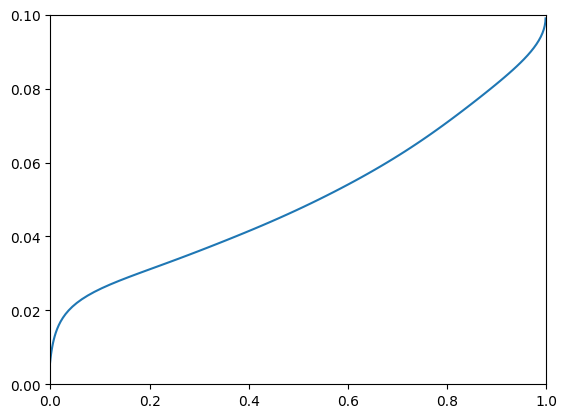

In [60]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d') 

x=np.arange(0,0.1,0.001)[:,np.newaxis]
pt_x = torch.tensor(x, dtype=torch.float32, requires_grad=False).to(device)
pt_u = net(pt_x)
u=pt_u.data.cpu().numpy()



plt.plot(u,x)
plt.xlim(0, 1) 
plt.ylim(0, 0.1) 
plt.show()

In [ ]:
# Load arrays from the .npz file
loaded_data = np.load('solver_lam.npz')
lam01 = loaded_data['lam01']
lam10 = loaded_data['lam10']
lam10 = loaded_data['lam003']

In [ ]:
# np.savez('solver_lam.npz', lam01=lam01,lam10=lam10,lam003=u)

In [ ]:
# for i in loaded_data.values():
    
plt.plot(loaded_data['lam01'],x,linestyle='--',label="$\lambda=0.1$")
plt.plot(loaded_data['lam003'],x,linestyle='--',label="$\lambda=0.3$")
plt.plot(loaded_data['lam10'],x,linestyle='--',label="$\lambda=10$")
plt.plot(u,x,label="full model")
plt.xlim(0, 1) 
plt.ylim(0, 0.1) 
plt.xlabel('${c_l}$', fontsize=12)
plt.ylabel('$z/h$', fontsize=12)
plt.legend()
plt.savefig('comparison.png')
plt.show()
